blablabla

In [ ]:
# import the libraries used
import os
from email.parser import Parser
from tqdm import tqdm
import json
import networkx as nx
import matplotlib.pyplot as plt
# set root directory of dataset
dataroot = os.path.join('..', 'EnronEmails_Filtered', 'maildir')

In [ ]:
def splitEmails(maillist: str, tag):
    """
    Splits email of type tag [to,cc,bcc] addresses from maillist
    :param maillist: email with lists of addresses
    :param tag: tag specified to split from
    :return: list of split emails, Duplicates are included
    """
    split = maillist[tag]
    split = split.replace("\n", "")
    split = split.replace("\t", "")
    split = split.replace(" ", "")
    return split.split(',')

In [ ]:
def readMail(email):
    """
    converts python email object into dict of dicts as written:
        {subject: "", text: "", tos: [], ccs: [], bccs: []}
    between all duplicates that existed in tos,ccs and bccs, are removed
    :param email: email being read
    :return: returns dict of dicts {subject: "", text: "", tos: [], cc: [], bcc: []}
    """
    update = {'subject': email['subject'], 'text': email.get_payload(), 'tos': [], 'ccs': [], 'bccs': []}
    if email['to']:
        update['tos'] = list(set(splitEmails(email, 'to')))
    if email['cc']:
        update['ccs'] = list(set(splitEmails(email, 'cc')))
        # This for if is O(n^2) it slows the parsing by a bit but it does remove duplicates in cc and bcc
        # Still takes around a minute
        for a in update['ccs']:
            if a in update['tos']:
                update['ccs'].remove(a)
    if email['bcc']:
        update['bccs'] = list(set(splitEmails(email, 'bcc')))
        for a in update['bccs']:
            if a in update['ccs']:
                update['bccs'].remove(a)
    return update

In [ ]:
def addMail(dic, emailDir):
    """
    Add email from emailDir(a MIME file) into dic
    :param dic: dict to add email to
    :param emailDir: file from which the email are being read
    :return: updated dic
    """
    with open(emailDir, "r", encoding='utf-8', errors='ignore') as f:
        email = Parser().parsestr(f.read())
        key = email['from']
        if key in dic:
            value = dic.get(email['from'])
            value.append(readMail(email))
            dic.update({key: value})
        else:
            value = [readMail(email)]
            dic.update({key: value})

In [ ]:
def addAll(dic, emailDir):
    """
    add all emails in emailDir(MIME file or directory) into dic
    :param dic: dict to add emails to
    :param emailDir: (MIME file or directory) from which the emails are being read
    :return: updated dic
    """
    if not os.path.isfile(emailDir):
        for file in os.listdir(emailDir):
            addAll(dic, os.path.join(emailDir, file))
    else:
        addMail(dic, emailDir)

In [ ]:
def loadData(dic, root):
    """
    loads data from root into dic, tqdm progress bar indicates progress
    :param dic: dictionary that will be loaded with emails
    :param root: root directory
    :return: dic filled with data from root
    """
    for user in tqdm(os.listdir(root)):
        userPath = os.path.join(root, user)
        for folder in os.listdir(userPath):
            folderPath = os.path.join(root, user, folder)
            if os.path.isfile(folderPath):
                addMail(dic, folderPath)
                continue

            for file in os.listdir(folderPath):
                addAll(dic, os.path.join(dataroot, user, folder, file))

In [ ]:
def _saveToFile(data, path):
    """
    ethan code than code
    :param data:
    :param path:
    :return:
    """
    print('Saving')
    with open(path, 'w') as fp:
        json.dump(data, fp, indent=4)

In [ ]:
class Edge:
    """
    Simple edge class that represents and edge with weight between 2 aliases
    """
    def __init__(self, alias1: str, alias2: str, weight=0):
        self.alias1 = alias1
        self.alias2 = alias2
        self.weight = weight

In [ ]:
edges = {}
def addEdgeToDict(frm, to):
    """
    Adds edge from -> to to dictionary, incrementing weight if the tuple(frm, to) already exists in edges
    :param frm: from user
    :param to: to user
    :return: dictionary of edges key=tuple(frm,to):value=weight
    """
    key = tuple([frm, to])
    if key in edges:
        w = edges.get(key)
        w += 1
        edges[key] = w
    else:
        edges.update({key: 1})

load the intermediary file into myDict to avoid parsing through dataset each time
or if not created, create the intermediary file

In [ ]:
myDict = {}
path = "../intermediary/file.json"
if os.path.isfile(path) and os.access(path, os.R_OK):
    print("Docs file found!")
    print('Reading...')
    with open(path, 'r') as f:
        myDict = json.load(f)
    print("...done!")

else:
    print("Either file is missing or is not readable, creating file...")
    loadData(myDict, dataroot)
    _saveToFile(myDict, path=path)

build networkx directed graph with edges

In [ ]:
G = nx.DiGraph()
print("\nBuilding Edges")
# weight dict
for _from in tqdm(myDict):
    emails = myDict.get(_from)
    for e in emails:
        for t in e['tos']:
            addEdgeToDict(_from, t)
        for c in e['ccs']:
            addEdgeToDict(_from, c)
        for b in e['bccs']:
            addEdgeToDict(_from, b)

for edge in tqdm(edges.keys()):
    G.add_edge(edge[0], edge[1], weight=edges.get(edge))

print("\nDone.")

In [4]:
def plot_degree_dist(graph):
    degrees = [graph.degree(n) for n in graph.nodes]
    plt.hist(degrees)
    plt.show()

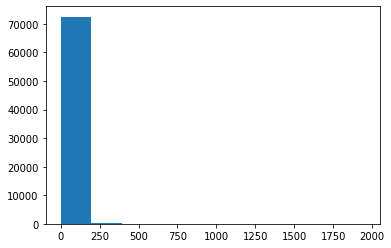

In [5]:
plot_degree_dist(G)
